<h1 style = 'text-align: center'> TOOL CALLING</h1>

**Description**: Tool calling allows a chat model to respond to a given prompt by "calling a tool"

- The model only **generates the args** to a tool
- This is a general technique that generates structured output from a model. 

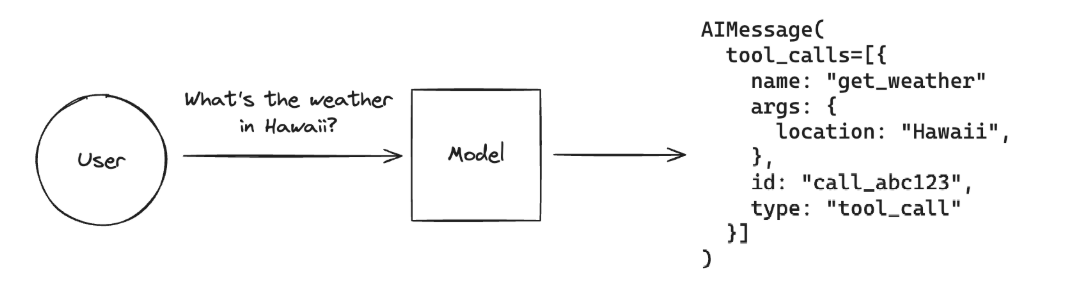

- LangChain implements standard interfaces for defining tools, passing them to LLMs, and representing tool calls.

## **1. Defining tool schemas**

- For a model to be able to call tools: need to pass in tool **schemas** that describe what the tool does & what  its arguments are


In [1]:
from pydantic import BaseModel, Field

In [4]:
class add(BaseModel):
    '''Add two integers'''

    a:int = Field(description = 'First integer')
    b:int = Field(description = 'Second integer')

class multiply(BaseModel):
    '''Multiply two integers'''

    a:int = Field(description = 'First integer')
    b:int = Field(description = 'Second integer')

# define tools
tools = [add, multiply]


In [8]:
from dotenv import load_dotenv
import os

load_dotenv()

from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model = 'gpt-4o',
    base_url = os.getenv('OPENAI_API_URL'),
    api_key = os.getenv('OPENAI_API_KEY'),
    temperature = 0.5
)

- `bind_tools()`: is a method for passing tool schemas to the model

In [ ]:
llm_with_tools = llm.bind_tools(tools)

query = "What is 3*12?"

llm_with_tools.invoke(query)

"""
Output will be as below:

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gIKLyDuW8KOJmmwGlw8XTeD6', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 86, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BqaPQpvb6TrqDZ0MjRZS71lzM24PU', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b0dc006d-a918-4356-8a39-a4c1f940e040-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_gIKLyDuW8KOJmmwGlw8XTeD6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 18, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

"""
# --> LLM generated args to a tool


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gIKLyDuW8KOJmmwGlw8XTeD6', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 86, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BqaPQpvb6TrqDZ0MjRZS71lzM24PU', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b0dc006d-a918-4356-8a39-a4c1f940e040-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_gIKLyDuW8KOJmmwGlw8XTeD6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 18, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

## **2. Tool Calls**

- `tool_calls`: if tool calls are included in a LLM response -> they are attached to the correspondong msg or msg chunk as a list of tool call objects in this attribute
- chat models can call multiple tools at once
- A `ToolCall` is a typed dict that includes **a tool name**, **dict of arg values** and (optionally) an identifier.

In [10]:
query = "What is 3 * 12? Also, what is the result plus 11?"

llm_with_tools.invoke(query).tool_calls


[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'call_q4nYvZvY3cf8g5CditJt8Vqk',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 36, 'b': 11},
  'id': 'call_4kERifOh5z0d6keuzzMB8JSz',
  'type': 'tool_call'}]

## **3. Parsing**

- **Output Parser** can process the output. 
- Ex: Convert existing value from `.tool_calls` to Pydantic object by using **PydanticToolsParser**

In [11]:
from langchain_core.output_parsers import PydanticToolsParser

chain = llm_with_tools | PydanticToolsParser (tools = tools)
chain.invoke(query)

[multiply(a=3, b=12), add(a=36, b=11)]